In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [2]:
data = pd.read_csv('clean.csv')

In [3]:
data

,date,AQI,latitude,longitude
0,2023-04-01 00:00:00,45.765,27.889417,71.375264
1,2023-04-01 01:00:00,46.520,27.889417,71.375264
2,2023-04-01 02:00:00,47.640,27.889417,71.375264
3,2023-04-01 03:00:00,49.330,27.889417,71.375264
4,2023-04-01 04:00:00,51.210,27.889417,71.375264
...,...,...,...,...
9236,2024-04-19 20:00:00,64.075,27.889417,71.375264
9237,2024-04-19 21:00:00,64.950,27.889417,71.375264
9238,2024-04-19 22:00:00,63.735,27.889417,71.375264
9239,2024-04-19 23:00:00,61.845,27.889417,71.375264


In [5]:
data = data[['date', 'AQI']]
data

,date,AQI
0,2023-04-01 00:00:00,45.765
1,2023-04-01 01:00:00,46.520
2,2023-04-01 02:00:00,47.640
3,2023-04-01 03:00:00,49.330
4,2023-04-01 04:00:00,51.210
...,...,...
9236,2024-04-19 20:00:00,64.075
9237,2024-04-19 21:00:00,64.950
9238,2024-04-19 22:00:00,63.735
9239,2024-04-19 23:00:00,61.845


In [6]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

<ipython-input-7-d9d23a9e1226>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])


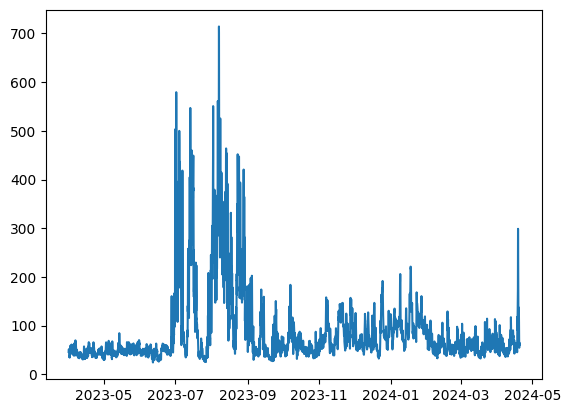

In [7]:
data['date'] = pd.to_datetime(data['date'])

plt.plot(data['date'], data['AQI'])

In [9]:
from copy import deepcopy as dc

def prepare_data(df, n_steps):
  df = dc(df)
  df['date'] = pd.to_datetime(df['date'])

  df.set_index('date', inplace=True)

  for i in range(1, n_steps+1):
    df[f"AQI(t-{i})"] = df['AQI'].shift(i)

  df.dropna(inplace=True)

  return df

lookback = 7
shifted_df = prepare_data(data, lookback)
shifted_df

,AQI,AQI(t-1),AQI(t-2),AQI(t-3),AQI(t-4),AQI(t-5),AQI(t-6),AQI(t-7)
date,,,,,,,,
2023-04-01 07:00:00,47.205,49.650,51.400,51.210,49.330,47.640,46.520,45.765
2023-04-01 08:00:00,44.425,47.205,49.650,51.400,51.210,49.330,47.640,46.520
2023-04-01 09:00:00,42.035,44.425,47.205,49.650,51.400,51.210,49.330,47.640
2023-04-01 10:00:00,40.915,42.035,44.425,47.205,49.650,51.400,51.210,49.330
2023-04-01 11:00:00,40.240,40.915,42.035,44.425,47.205,49.650,51.400,51.210
...,...,...,...,...,...,...,...,...
2024-04-19 20:00:00,64.075,61.375,57.480,54.325,55.820,68.255,86.095,105.880
2024-04-19 21:00:00,64.950,64.075,61.375,57.480,54.325,55.820,68.255,86.095
2024-04-19 22:00:00,63.735,64.950,64.075,61.375,57.480,54.325,55.820,68.255


In [10]:
# converting to an array
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[47.205, 49.65 , 51.4  , ..., 47.64 , 46.52 , 45.765],
       [44.425, 47.205, 49.65 , ..., 49.33 , 47.64 , 46.52 ],
       [42.035, 44.425, 47.205, ..., 51.21 , 49.33 , 47.64 ],
       ...,
       [63.735, 64.95 , 64.075, ..., 54.325, 55.82 , 68.255],
       [61.845, 63.735, 64.95 , ..., 57.48 , 54.325, 55.82 ],
       [60.765, 61.845, 63.735, ..., 61.375, 57.48 , 54.325]])

In [11]:
# scaling the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.51809868, -0.485499  , -0.46216203, ..., -0.51218743,
        -0.52708496, -0.53712404],
       [-0.55514309, -0.51807922, -0.48548106, ..., -0.48966847,
        -0.51216129, -0.52706397],
       [-0.58699062, -0.55512339, -0.51806108, ..., -0.4646178 ,
        -0.48964254, -0.51214041],
       ...,
       [-0.297831  , -0.28162283, -0.2932656 , ..., -0.42311096,
        -0.40316521, -0.23745376],
       [-0.32301587, -0.29781299, -0.28160609, ..., -0.38107113,
        -0.42308564, -0.40314518],
       [-0.33740722, -0.3229977 , -0.29779616, ..., -0.32917093,
        -0.3810462 , -0.42306546]])

In [12]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((9234, 7), (9234,))

In [13]:
X = dc(np.flip(X, axis=1))
X

array([[-0.53712404, -0.52708496, -0.51218743, ..., -0.46467253,
        -0.46216203, -0.485499  ],
       [-0.52706397, -0.51216129, -0.48966847, ..., -0.46214077,
        -0.48548106, -0.51807922],
       [-0.51214041, -0.48964254, -0.4646178 , ..., -0.48545964,
        -0.51806108, -0.55512339],
       ...,
       [-0.23745376, -0.40316521, -0.42311096, ..., -0.3292232 ,
        -0.2932656 , -0.28162283],
       [-0.40314518, -0.42308564, -0.38107113, ..., -0.29324551,
        -0.28160609, -0.29781299],
       [-0.42306546, -0.3810462 , -0.32917093, ..., -0.28158607,
        -0.29779616, -0.3229977 ]])

In [14]:
split_index = int(len(X) * 0.95)

split_index

8772

In [15]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8772, 7), (462, 7), (8772,), (462,))

In [16]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8772, 7, 1), (462, 7, 1), (8772, 1), (462, 1))

In [17]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([8772, 7, 1]),
 torch.Size([462, 7, 1]),
 torch.Size([8772, 1]),
 torch.Size([462, 1]))

In [18]:
# Creating a dataset
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [19]:
train_dataset

In [20]:
# Data Loader
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [21]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [22]:
# LSTM Model


class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_stacked_layers):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_stacked_layers = num_stacked_layers

    self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    batch_size = x.size(0)
    h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    return out



In [23]:
model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [24]:
def train_one_epoch():
  model.train(True)
  print(f'Epoch: {epoch +1 }')

  running_loss = 0.0

  for batch_index, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    output = model(x_batch)
    loss = loss_function(output, y_batch)
    running_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch_index % 100==99: # printing every 100 batch
      avg_loss_across_batches = running_loss/100
      print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                  avg_loss_across_batches))
      running_loss = 0.0
  print()

In [25]:
def validate_one_epoch():
  model.train(False)
  running_loss = 0.0

  for batch_index, batch in enumerate(test_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    with torch.no_grad():
      output = model(x_batch)
      loss = loss_function(output, y_batch)
      running_loss += loss.item()

  avg_loss_across_batches = running_loss / len(test_loader)

  print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
  print('***************************************************')
  print()

In [26]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 1.165
Batch 200, Loss: 0.849
Batch 300, Loss: 0.704
Batch 400, Loss: 0.590
Batch 500, Loss: 0.517

Val Loss: 0.044
***************************************************

Epoch: 2
Batch 100, Loss: 0.403
Batch 200, Loss: 0.357
Batch 300, Loss: 0.356
Batch 400, Loss: 0.250
Batch 500, Loss: 0.237

Val Loss: 0.022
***************************************************

Epoch: 3
Batch 100, Loss: 0.166
Batch 200, Loss: 0.152
Batch 300, Loss: 0.133
Batch 400, Loss: 0.098
Batch 500, Loss: 0.089

Val Loss: 0.015
***************************************************

Epoch: 4
Batch 100, Loss: 0.083
Batch 200, Loss: 0.076
Batch 300, Loss: 0.085
Batch 400, Loss: 0.080
Batch 500, Loss: 0.037

Val Loss: 0.010
***************************************************

Epoch: 5
Batch 100, Loss: 0.059
Batch 200, Loss: 0.043
Batch 300, Loss: 0.036
Batch 400, Loss: 0.048
Batch 500, Loss: 0.052

Val Loss: 0.009
***************************************************

Epoch: 6
Batch 100, Loss: 0.03

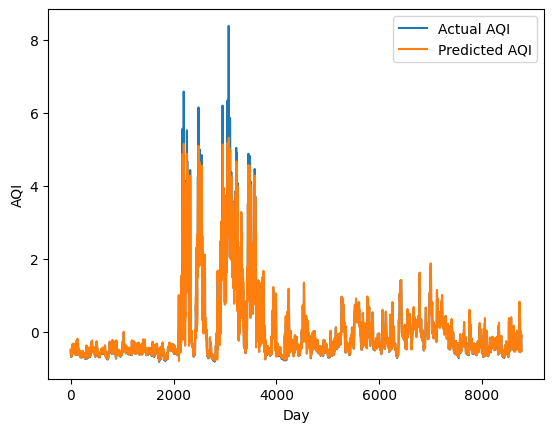

In [27]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual AQI')
plt.plot(predicted, label='Predicted AQI')
plt.xlabel('Day')
plt.ylabel('AQI')
plt.legend()
plt.show()


In [28]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([49.86648379, 47.27692821, 44.46791665, ..., 47.31621934,
       46.64717873, 46.9747211 ])

In [29]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([47.20500183, 44.42499789, 42.03499777, ..., 46.91000078,
       46.68499823, 46.8399978 ])

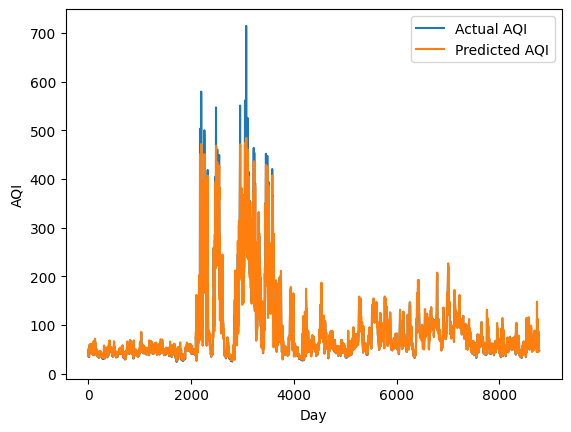

In [30]:
plt.plot(new_y_train, label='Actual AQI')
plt.plot(train_predictions, label='Predicted AQI')
plt.xlabel('Day')
plt.ylabel('AQI')
plt.legend()
plt.show()


In [31]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([ 47.39111582,  47.77409698,  48.71453444,  49.53704485,
        50.8520989 ,  52.12916794,  53.8543813 ,  52.91626981,
        52.68123872,  53.04023547,  51.32871854,  48.17776144,
        48.03289777,  49.42962941,  52.57872574,  53.06055199,
        53.93543268,  55.81979658,  51.60201196,  51.77069007,
        48.00186386,  44.96645416,  44.39326172,  44.58103073,
        45.11396587,  44.92022089,  44.26708638,  43.17127361,
        42.13991726,  41.0612541 ,  61.27498338,  55.91049181,
        56.07084113,  54.23559114,  66.32397398,  73.85831635,
        73.15596953,  67.31594079,  61.71360907,  59.30400365,
        59.17764044,  59.23174626,  57.32304905,  57.17350659,
        53.00486272,  51.80658169,  48.15039542,  44.6502554 ,
        42.2132929 ,  40.80511029,  39.66731362,  39.14777969,
        38.75143311,  38.24338593, 115.68266536, 107.00300491,
        88.42017954,  78.56006981,  68.80928103,  59.05685958,
        57.13071755,  59.40275034,  62.79270164,  63.21

In [32]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([ 47.10000183,  47.88500138,  48.71499964,  49.93000087,
        51.22500007,  52.87000075,  52.50499896,  52.20499929,
        52.54499906,  51.25500071,  48.33999838,  47.65999883,
        48.77999953,  51.45999985,  52.33999992,  53.115     ,
        54.87500014,  51.96000004,  51.34500039,  48.4050005 ,
        45.05499787,  44.02500132,  44.02000046,  44.35499939,
        44.18500174,  43.54500006,  42.4950001 ,  41.42500121,
        40.31499997,  56.4650004 ,  55.98499914,  54.93000056,
        54.119999  ,  63.13500056,  70.89499966,  72.26500046,
        68.64999965,  63.67      ,  60.67000108,  59.85000005,
        59.5650007 ,  57.87499906,  57.27000111,  53.88000061,
        52.01500047,  48.74500028,  44.95999957,  42.15500033,
        40.40999826,  39.04499832,  38.28000218,  37.77000029,
        37.18999988,  92.35500004, 100.8599997 ,  94.30999985,
        84.44999999,  74.17500044,  63.66499915,  59.344999  ,
        60.05000057,  62.44499931,  63.08000013,  63.30

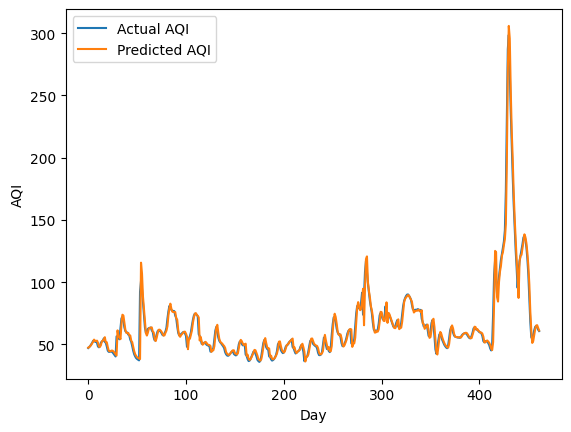

In [33]:
plt.plot(new_y_test, label='Actual AQI')
plt.plot(test_predictions, label='Predicted AQI')
plt.xlabel('Day')
plt.ylabel('AQI')
plt.legend()
plt.show()


In [35]:
# Saving the model

torch.save(model.state_dict(), "lstm_model.pt")  # Replace "lstm_model.pt" with your desired filename